In [1]:
import numpy as np
import pandas as pd
train = pd.read_csv('train.csv', sep='\t')
test = pd.read_csv('test.csv', sep='\t')
sample_submission = pd.read_csv('sample_submission.csv')

x_train = train["text"]
y_train = train["label"]
y_train = y_train.replace('label', 0 , regex=True)  #把label轉為0  df.replace or series.replace

x_test = test["text"]
y_test = sample_submission["label"]

In [2]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

#--建立Token--
token = Tokenizer(num_words=3800) 
#使用Tokenizer模組建立token，建立一個3800字的字典
token.fit_on_texts(x_train)  
#讀取所有訓練資料，依照每個英文字在訓練資料出現的次數進行排序，前3800名的英文單字會加進字典中
token.word_index
#可以看到它將英文字轉為數字的結果，例如:the轉換成1

x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)
#透過texts_to_sequences可以將訓練和測試集資料中的文字轉換為數字list


In [3]:
#截長補短
x_train = sequence.pad_sequences(x_train_seq, maxlen=380)
x_test = sequence.pad_sequences(x_test_seq, maxlen=380)

y_train = np.asarray(y_train).astype('float32')

#長度小於380的，前面的數字補0
#長度大於380的，截去前面的數字
#變成25000*380的矩陣 = 25000則評論，每則包含380個數字

In [28]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.embeddings import Embedding
    #利用Keras 建立RNN模型
from keras.layers.recurrent import SimpleRNN
    #利用Keras 建立LSTM模型
from keras.layers.recurrent import LSTM 
import keras

train_history_RNN = keras.callbacks.History()
train_history_LSTM = keras.callbacks.History()

def RNN(x_train, x_test, y_train, y_test, train_history_RNN):
    modelRNN = Sequential()
    modelRNN.add(Embedding(output_dim=32,   #輸出的維度是32，希望將數字list轉換為32維度的向量
                           input_dim=3800,  #輸入的維度是3800，也就是我們之前建立的字典是3800字
                           input_length=380)) #數字list截長補短後都是380個數字

    #--建立RNN層--
    modelRNN.add(SimpleRNN(units=16))
    #建立16個神經元的RNN層

    #--建立隱藏層--
    modelRNN.add(Dense(units=256,activation='relu')) 
    #建立256個神經元的隱藏層.  ReLU激活函數
    modelRNN.add(Dropout(0.35))
    #隨機在神經網路中放棄20%的神經元，避免overfitting

    #--建立輸出層--
    modelRNN.add(Dense(units=1,activation='sigmoid'))
    #建立一個神經元的輸出層.   Sigmoid激活函數

    # 查看模型摘要
    print('模型摘要：')
    modelRNN.summary()

    # 定義訓練模型
    modelRNN.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy']) 
    # Loss function使用Cross entropy                        
    # adam最優化方法可以更快收斂

    train_history_RNN = modelRNN.fit(x_train,y_train, 
                                epochs=10, 
                                batch_size=100,
                                verbose=2,
                                validation_split=0.2)

    #validation_split =0.2 設定80%訓練資料、20%驗證資料
    #執行10次訓練週期
    #每一批次訓練100筆資料
    #verbose 顯示訓練過程

    scores = modelRNN.evaluate(x_test, y_test,verbose=1)
    print(scores[1])
    #使用test測試資料及評估準確率

    return train_history_RNN

def LSTM_(x_train, x_test, y_train, y_test, train_history_LSTM):

    modelLSTM = Sequential() #建立模型
    modelLSTM.add(Embedding(output_dim=32,   #輸出的維度是32，希望將數字list轉換為32維度的向量
                            input_dim=3800,  #輸入的維度是3800，也就是我們之前建立的字典是3800字
                            input_length=380)) #數字list截長補短後都是380個數字
    modelLSTM.add(Dropout(0.2)) #隨機在神經網路中放棄20%的神經元，避免overfitting

    #建立LSTM層
    modelLSTM.add(LSTM(32)) 
    #建立32個神經元的LSTM層

    #建立隱藏層
    modelLSTM.add(Dense(units=256,activation='relu')) 
    #建立256個神經元的隱藏層
    modelLSTM.add(Dropout(0.2))

    #建立輸出層
    modelLSTM.add(Dense(units=1,activation='sigmoid'))
    #建立一個神經元的輸出層

    #查看模型摘要
    modelLSTM.summary()

    #訓練模型參數同RNN
    modelLSTM.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy']) 

    train_history_LSTM = modelLSTM.fit(x_train,y_train, 
                                  epochs=10, 
                                  batch_size=100,
                                  verbose=2,
                                  validation_split=0.2)

    #評估模型準確率
    scores = modelLSTM.evaluate(x_test, y_test,verbose=1)
    print(scores[1])

    return train_history_LSTM

In [22]:
#--繪圖區--
import matplotlib.pyplot as plt  

def show_train(train, val, train_history):
    plt.figure()
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


In [23]:
train_history_RNN = RNN(x_train, x_test, y_train, y_test, train_history_RNN)

模型摘要：
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dense_8 (Dense)              (None, 256)               4352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 126,993
Trainable params: 126,993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40/40 - 3s - loss: 0.6754 - accuracy: 0.5949 - val_loss: 0.6691 - val_accuracy: 0.5932
Epoch 2/10

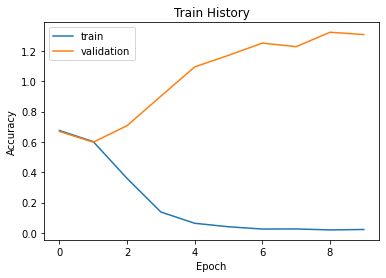

In [24]:
#畫出loss圖
show_train('loss', 'val_loss', train_history_RNN)

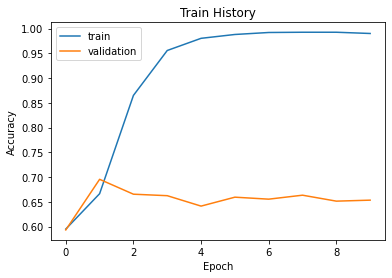

In [25]:
#畫出accuracy圖
show_train('accuracy', 'val_accuracy', train_history_RNN)

In [29]:
train_history_LSTM = LSTM_(x_train, x_test, y_train, y_test, train_history_LSTM)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 380, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 138,625
Trainable params: 138,625
Non-trainable params: 0
________________________________________________

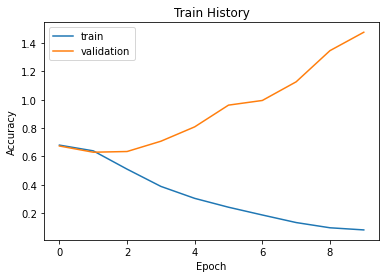

In [33]:
#畫出loss圖
show_train('loss', 'val_loss', train_history_LSTM)

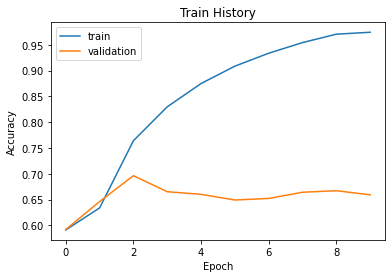

In [34]:
#畫出accuracy圖
show_train('accuracy', 'val_accuracy', train_history_LSTM)

In [35]:
# train_history_LSTM.history

{'loss': [0.6797505617141724,
  0.6393700242042542,
  0.5102100968360901,
  0.3883775770664215,
  0.3039126396179199,
  0.24141621589660645,
  0.18659305572509766,
  0.13323600590229034,
  0.0963178351521492,
  0.08121776580810547],
 'accuracy': [0.5913763046264648,
  0.6339935064315796,
  0.7641012668609619,
  0.8297818899154663,
  0.8749060034751892,
  0.9084983468055725,
  0.9335672855377197,
  0.954123854637146,
  0.9704186320304871,
  0.9741789698600769],
 'val_loss': [0.6735150218009949,
  0.6296831369400024,
  0.6346026062965393,
  0.7072102427482605,
  0.8086761236190796,
  0.9620623588562012,
  0.9948993921279907,
  1.1265584230422974,
  1.3466124534606934,
  1.4764870405197144],
 'val_accuracy': [0.5921843647956848,
  0.6462925672531128,
  0.6963927745819092,
  0.6653306484222412,
  0.6603206396102905,
  0.6492986083030701,
  0.6523045897483826,
  0.6643286347389221,
  0.6673346757888794,
  0.6593186259269714]}